In [150]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc

In [151]:
# Import the CSV file named 'water_potability.csv' into a pandas DataFrame
df = pd.read_csv("water_potability.csv")

# Display the first five rows of the DataFrame to preview the data
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [152]:
# Display a concise summary of the DataFrame, including:
# - Number of rows and columns
# - Column names and data types
# - Non-null counts for each column (to check missing values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [153]:
# Get the dimensions of the DataFrame `df` as (number of rows, number of columns)
df.shape

(3276, 10)

In [154]:
# Summary statistics (count, mean, std, min, max, quartiles) of numeric columns
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [155]:
# Print the count of missing (NaN) values in each column of the DataFrame
print(df.isna().sum())

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


In [156]:
# Print the total number of duplicate rows in the DataFrame
print(df.duplicated().sum())

0


In [157]:
# Initialize a dictionary to store the outlier count for each column
count_outlier = {}

# Loop through each column in the DataFrame
for col in df.columns:
    # Calculate the 25th percentile (Q1) of the column
    q1 = df[col].quantile(.25)
    # Calculate the 75th percentile (Q3) of the column
    q3 = df[col].quantile(.75)

    # Compute the interquartile range (IQR)
    iqr = q3 - q1

    # Define the upper whisker for outlier detection
    upper_whisker = q3 + 1.5 * iqr
    # Define the lower whisker for outlier detection
    lower_whisker = q1 - 1.5 * iqr

    # Identify outliers as values outside the whiskers
    counts = (df[col] > upper_whisker) | (df[col] < lower_whisker)
    # Store the count of outliers for this column
    count_outlier[col] = counts.sum()

# Convert the outlier counts dictionary into a DataFrame for display
outlier_df = pd.DataFrame(
    {
        'Columns': count_outlier.keys(),       # Column names
        'Outlier Count': count_outlier.values() # Corresponding outlier counts
    }
)

# Display the DataFrame showing outlier counts per column
outlier_df

,Columns,Outlier Count
0,ph,46
1,Hardness,83
2,Solids,47
3,Chloramines,61
4,Sulfate,41
5,Conductivity,11
6,Organic_carbon,25
7,Trihalomethanes,33
8,Turbidity,19
9,Potability,0


In [158]:
# Create a copy of the original DataFrame to keep the original data unchanged
df_copy = df.copy()

# Define different IQR multipliers to test outlier removal strength
iqr_factors = [1, 1.5, 2, 2.5, 3]

# Initialize a list to store results for each IQR factor
result = []

# Loop through each IQR factor
for k in iqr_factors:
    # Create a temporary copy of the DataFrame for current IQR factor
    df_temp = df_copy.copy()

    # Loop through only numerical columns for outlier detection
    for col in df_temp.select_dtypes(include='number'):
        # Calculate the first quartile (Q1) of the column
        q1 = df_temp[col].quantile(.25)
        # Calculate the third quartile (Q3) of the column
        q3 = df_temp[col].quantile(.75)

        # Compute the interquartile range (IQR)
        iqr = q3 - q1
        
        # Define the upper boundary for outlier removal
        upper_whisker = q3 + k * iqr
        # Define the lower boundary for outlier removal
        lower_whisker = q1 - k * iqr

        # Remove rows containing outliers based on current column and IQR factor
        df_temp = df_temp[
            (df_temp[col] <= upper_whisker) & 
            (df_temp[col] >= lower_whisker)
        ]

    # Calculate how many rows were removed after outlier filtering
    row_removed = len(df_copy) - len(df_temp)
    # Calculate percentage of data loss due to outlier removal
    row_loss_percent = row_removed / len(df_copy) * 100

    # Store results for the current IQR factor
    result.append((k, len(df_copy), len(df_temp), row_loss_percent))

# Create a DataFrame summarizing the effect of different IQR factors
optimum_df = pd.DataFrame(
    result,
    columns=['IQR_Factor', 'Total_rows', 'Remaining_Rows', 'Row_loss_parcent']
)

# Display the DataFrame to analyze optimal IQR factor selection
optimum_df


,IQR_Factor,Total_rows,Remaining_Rows,Row_loss_parcent
0,1.0,3276,1230,62.454212
1,1.5,3276,1791,45.329670
2,2.0,3276,1966,39.987790
3,2.5,3276,2003,38.858364
4,3.0,3276,2009,38.675214


In [159]:
# Remove outliers from a DataFrame column using the IQR method with a factor of 3
def outlier(df, col2):
    q1 = df[col2].quantile(.25)  # Calculate the first quartile (Q1)
    q3 = df[col2].quantile(.75)  # Calculate the third quartile (Q3)

    iqr = q3 - q1  # Compute the interquartile range (IQR)

    upper_whisker = q3 + 3 * iqr  # Define the upper bound for outlier removal
    lower_whisker = q1 - 3 * iqr  # Define the lower bound for outlier removal

    df = df[(df[col2] <= upper_whisker) & (df[col2] >= lower_whisker)]  # Filter out outliers

    return df  # Return the DataFrame without outliers

In [160]:
# Apply the outlier removal function iteratively on all columns and update the cleaned DataFrame
df_clean = df.copy()

for col3 in df_clean.columns:
    df_clean = outlier(df_clean, col3)  # Remove outliers column by column

df = df_clean.copy()  # Update the original DataFrame with the cleaned data

Visualization

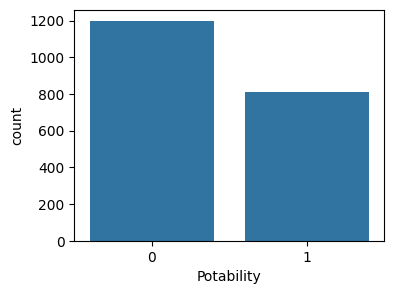

In [161]:
plt.figure(figsize=(4,3))
sns.countplot(data=df, x='Potability')
plt.show()

In [162]:
# Separate features (X) and target variable (y) by dropping the target column from the DataFrame
x = df.drop(['Potability'], axis=1)
y = df[['Potability']]

In [163]:
# Standardize each feature column using StandardScaler to bring them to zero mean and unit variance
stands = StandardScaler()

for col4 in x.columns:
    x[col4] = stands.fit_transform(x[[col4]])  # Scale each column independently

x.head()  # Display the first few rows of the scaled feature set

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
3,0.788927,0.564999,0.013848,0.582828,0.575930,-0.783084,1.226256,2.111063,0.844347
4,1.284238,-0.454729,-0.455321,-0.373106,-0.565749,-0.347526,-0.843124,-2.139123,0.134745
5,-0.956529,-0.233699,0.795550,0.257725,-0.161766,-1.809242,-1.793400,-0.713773,-1.807312
6,2.007055,1.597797,0.795669,0.237845,1.474058,-1.769785,-0.171783,1.132334,-1.662134
7,0.992736,0.227503,-0.955554,-1.626588,-0.732445,0.596814,-0.600771,-0.223700,0.552987


In [164]:
# Split the dataset into training and testing sets with 80% data for training and 20% for testing
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

In [165]:
# Display the first few rows of the training feature set
xtrain.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
935,2.110703,0.151792,-0.454926,-0.816148,0.139119,-1.117543,-0.012413,-0.263602,1.219298
904,-0.723115,-1.087889,-0.580780,-0.689507,0.830941,0.304393,0.601501,-0.250446,0.131057
1727,0.203182,1.902693,-0.390736,-1.036274,0.159626,-0.889657,0.186030,0.411256,-0.224033
1899,-0.129165,0.575986,-0.161428,1.199535,-0.291076,-1.483092,-0.566628,0.826897,0.936236
2206,1.098820,0.918131,0.204421,-2.956412,1.834373,0.254567,-0.005973,-1.467307,-0.256447


In [166]:
# Display the first few rows of the training target variable
ytrain.head()

,Potability
935,0
904,0
1727,0
1899,1
2206,0


In [167]:
# Get the dimensions of the training target variable (rows, columns)
ytrain.shape

(1406, 1)

In [168]:
# Apply SMOTE to the training set to balance the target classes by oversampling the minority class
smote = SMOTE()
xtrain_res, ytrain_res = smote.fit_resample(xtrain, ytrain)

# Check the shape of the resampled training target variable
ytrain_res.shape

(1696, 1)

# Feature Importance (Grid Search)

In [169]:
# Initialize a Decision Tree classifier with default parameters
dect = DecisionTreeClassifier()

In [170]:
# Define a grid of hyperparameters for tuning the Decision Tree classifier
param_grid = {
    'criterion': ['gini', 'entropy'],                # Function to measure the quality of a split
    'max_depth': [None, 3, 5, 7, 10],               # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 20],            # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5, 10],             # Minimum samples required to be at a leaf node (note: typo in key)
    'splitter': ['best', 'random'],                 # Strategy used to choose the split at each node
    'ccp_alpha': [0.0, 0.001, 0.01, 1]             # Complexity parameter for Minimal Cost-Complexity Pruning
}

In [171]:
# Initialize GridSearchCV to find the best hyperparameters for the Decision Tree classifier
# Uses 5-fold cross-validation, evaluates by accuracy, and runs in parallel on all CPU cores
gridscv = GridSearchCV(
    estimator=dect,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [172]:
gridscv

,estimator,DecisionTreeClassifier()
,param_grid,"{'ccp_alpha': [0.0, 0.001, ...], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 3, ...], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [ ]:
# Fit the GridSearchCV object on the resampled training data to find the best Decision Tree model
model = gridscv.fit(xtrain_res, ytrain_res)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


In [ ]:
# Evaluate the accuracy of the best Decision Tree model on the resampled training data
model.score(xtrain_res, ytrain_res)

0.9563679245283019

In [ ]:
# Evaluate the accuracy of the best Decision Tree model on the unseen test data
model.score(xtest, ytest)

0.6086235489220564

In [ ]:
# Predict the target values for the test set using the trained Decision Tree model
pred_y = model.predict(xtest)

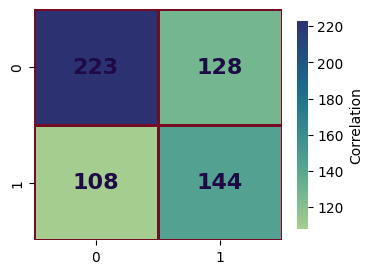

In [ ]:
# Compute and visualize the confusion matrix for the test set predictions
cm = confusion_matrix(ytest, pred_y)

# Set up the figure size for the heatmap
plt.figure(figsize=(4,3))

# Plot the confusion matrix as a heatmap with annotations and custom styling
sns.heatmap(
    cm, 
    annot=True,               # Show numbers in each cell
    fmt='g',                  # Display numbers as integers
    cmap='crest',             # Color map for the heatmap
    linewidths=2,             # Width of lines separating cells
    linecolor="#750C26",      # Color of lines separating cells
    annot_kws={               # Annotation text properties
        'color':"#1F0947",
        'fontweight': 'bold',
        'fontsize':16
    },
    cbar=True,                # Display color bar
    cbar_kws={                # Color bar styling
        'shrink':0.9,
        'label':'Correlation',
    }
)        

# Display the heatmap
plt.show()

In [ ]:
best_model = model.best_estimator_
best_param = model.best_params_
best_score = model.best_score_
best_index = model.best_index_

In [ ]:
print("Best Model", best_model)
print("Best Parameter", best_param)
print("Best Score", best_score)
print("Best Index", best_index)

Best Model DecisionTreeClassifier(ccp_alpha=0.001)
Best Parameter {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best Score 0.6639371854936664
Best Index 320
